In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import seaborn as sns
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn import metrics

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import sklearn.preprocessing as preproc

In [2]:
complaints = pd.read_csv('shared/complaints_25Nov21.csv')
complaints

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,NaN,NaN,JPMORGAN CHASE & CO.,FL,33133,NaN,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,JPMORGAN CHASE & CO.,NY,10312,NaN,NaN,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,NaN,NaN,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,NaN,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


In [3]:
#create a predictive model that can help the banks keep their total complaint related costs low

X = complaints[['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']]
X = pd.get_dummies(X, columns=['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?'])
y = complaints['Consumer disputed?']

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(complaints['Consumer disputed?'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(sum(y_train)/len(y_train))

0.21684719675769565


In [4]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state = 123)
X_train, y_train = undersampler.fit_resample(X, y)
print(sum(y_train)/len(y_train))

0.5


In [5]:
from xgboost import XGBClassifier

model_xgb =  XGBClassifier(objective= 'binary:logistic', random_state = 123)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

              precision    recall  f1-score   support

           0       0.85      0.53      0.66     32504
           1       0.28      0.66      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.57      0.60      0.52     41452
weighted avg       0.73      0.56      0.60     41452



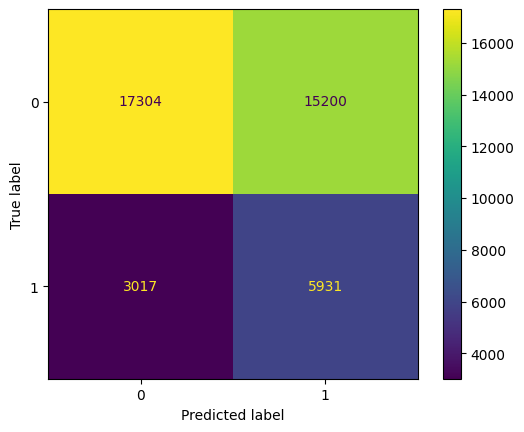

In [6]:
pred = model_xgb.predict(X_test)
print(classification_report(y_true = y_test, y_pred = pred))
ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test)

In [7]:
#The total cost in dollars for the test set without model

disputed_indices_test = (y_test == 1)
base_case_cost = sum(disputed_indices_test) * 600 + sum(~disputed_indices_test) * 100
print(f"Base-case total cost: ${base_case_cost}")

Base-case total cost: $8619200


In [8]:
#the total cost in dollars for the test set with model on default threshold

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, pred)

costs = {
    'true nodispute': 100,
    'false dispute': 190,
    'false nodispute': 600,
    'true dispute': 190
}

total_model_cost = (costs['true nodispute'] * conf_matrix[0, 0] +
                   costs['false dispute'] * conf_matrix[0, 1] +
                   costs['false nodispute'] * conf_matrix[1, 0] +
                   costs['true dispute'] * conf_matrix[1, 1])

print(f"Total cost based on model results and the confusion matrix: ${total_model_cost}")


Total cost based on model results and the confusion matrix: $7555490


In [10]:
#Get best threshold that leads to lowest costs

pred_prob = model_xgb.predict_proba(X_test)

thresholds = np.linspace(0, 1, num=100)

min_cost = float('inf')
best_threshold = None

for threshold in thresholds:
    y_pred_threshold = pred_prob[:,1] >= threshold
    conf_matrix = confusion_matrix(y_test, y_pred_threshold)
    total_cost = (costs['true nodispute'] * conf_matrix[0, 0] +
                  costs['false dispute'] * conf_matrix[0, 1] +
                  costs['false nodispute'] * conf_matrix[1, 0] +
                  costs['true dispute'] * conf_matrix[1, 1])
    if total_cost < min_cost:
        min_cost = total_cost
        best_threshold = threshold

print(f"Best threshold with the lowest total model cost: {best_threshold} and lowest cost is {min_cost}")


Best threshold with the lowest total model cost: 0.4646464646464647 and lowest cost is 7492230
